In [108]:
import geopandas as gp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import table
import seaborn as sns



In [83]:
udp_2017 = pd.read_csv('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/data/reference/udp_2017results.csv')
rec1_vars_dummies = pd.read_csv('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/data/regression/demog_with_cra_dummies_201314.csv')
loans_09 = pd.read_csv('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/data/regression/2009_loans.csv')
loans_1314 = pd.read_csv('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/data/regression/201314_loans.csv')
loans_151617 = pd.read_csv('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/data/regression/20151617_loans.csv')


In [142]:
rec1_udp_merge = pd.merge(rec1_vars_dummies, udp_2017, how='left', right_on='geo_fips', left_on='Geoid')
all_vars_09 = pd.merge(rec1_udp_merge, loans_09, how='left', on='Geoid').rename({"Percent of population 25 years and over with Bachelor's degree": "Pct Bachelor's degree"}, axis=1,inplace=False)
all_vars_1314 = pd.merge(rec1_udp_merge, loans_1314, how='left', on='Geoid').rename({"Percent of population 25 years and over with Bachelor's degree": "Pct Bachelor's degree"}, axis=1,inplace=False)
all_vars_151617 = pd.merge(rec1_udp_merge, loans_151617, how='left', on='Geoid').rename({"Percent of population 25 years and over with Bachelor's degree": "Pct Bachelor's degree"}, axis=1,inplace=False)


,Geoid,Pct Bachelor's degree,% below poverty level,% Single Family,% Owner Occupied,Percent NH White alone,Percent NH Black or African African alone,Percent NH Asian alone,Percent Hispanic,Total number of housing units,...,County_San Francisco County,County_San Mateo County,County_Santa Clara County,County_Solano County,County_Sonoma County,geo_fips,Typology,old disp type,Total loans 2013-2014,% Loans to MHI borrowers
0,6001400100,0.345,0.031,0.912439,0.895260,0.769150,0.041435,0.110724,0.007312,1439,...,0,0,0,0,0,6001400100,MHI - Advanced Exclusion,8.0,144,0.986111
1,6001400300,0.321,0.069,0.478758,0.405179,0.714142,0.099114,0.075544,0.085214,2801,...,0,0,0,0,0,6001400300,LI - Not Losing Low Income Households,2.0,123,1.000000
2,6001400400,0.440,0.040,0.555446,0.433809,0.698082,0.092588,0.078143,0.062988,2020,...,0,0,0,0,0,6001400400,MHI - Advanced Gentrification,6.0,104,0.980769
3,6001400500,0.281,0.060,0.444380,0.437722,0.419526,0.346635,0.066241,0.115988,1735,...,0,0,0,0,0,6001400500,LI - Ongoing Gentrification and/or Displacement,4.0,90,0.922222
4,6001400600,0.519,0.264,0.632653,0.470756,0.338305,0.473150,0.032220,0.059666,784,...,0,0,0,0,0,6001400600,LI - Ongoing Gentrification and/or Displacement,4.0,70,0.871429


In [143]:
def encode_udp(row):
    if (row == 'MHI - Advanced Gentrification'):
        return 6
    elif (row == 'LI - Ongoing Gentrification and/or Displacement'):
        return 5     
    elif (row == 'LI - At Risk of Gentrification and/or Displacement'):
        return 4    
    elif (row == 'MHI - Not Losing Low Income Households' or row == 'LI - Not Losing Low Income Households'):
        return 3 
    else:
        return np.nan #this includes all of the exclusion typologies, college town, or unreliable data


In [86]:
# all_vars_2009["UDP code"] = all_vars_2009["Typology"].apply(lambda x: encode_udp(x))
# all_vars_2009 = all_vars_151617.dropna()

# x_vars_2009 = all_vars_2009[['% Loans to MHI borrowers', 'CRA', "Percent of population 25 years and over with Bachelor's degree", 
#                 "% below poverty level","% Single Family","Percent NH White alone", 
#                 "Total number of housing units",  "Median home value", 'Median income',
#        'Total Loans', 'County_Alameda County', 'County_Contra Costa County','County_Marin County', 
#                   'County_Napa County','County_San Francisco County', 'County_San Mateo County',
#        'County_Santa Clara County', 'County_Solano County','County_Sonoma County']]
# x_vars_2009 = sm.add_constant(x_vars_2009)

# y_vars_2009 = all_vars_2009["UDP code"]


In [87]:
# mn = sm.MNLogit(y_vars_1314, x_vars_2009, J=4, K=20)
# results_mn = mn.fit()
# print(results_mn.summary())
# with open('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/new_regression_models/20151617_udp_multinomial.html', 'w') as outfile:
#     outfile.write(results_mn.summary().as_html())

In [144]:
all_vars_1314["UDP code"] = all_vars_1314["Typology"].apply(lambda x: encode_udp(x))
all_vars_1314 = all_vars_1314.dropna()
#do not include napa county
x_vars_1314 = all_vars_1314[['% Loans to MHI borrowers', 'CRA', "Pct Bachelor's degree", 
                "% below poverty level","% Single Family","Percent NH White alone", 
                "Total number of housing units",  "Median home value", 'Median income',
       'Total Loans', 'County_Alameda County', 'County_Contra Costa County','County_Marin County', 
                  'County_San Francisco County', 'County_San Mateo County',
       'County_Santa Clara County', 'County_Solano County','County_Sonoma County']]
x_vars_1314_constant = sm.add_constant(x_vars_1314)

y_vars_1314 = all_vars_1314["UDP code"]


/Users/ameliabaum/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [147]:
mn = sm.MNLogit(y_vars_1314, x_vars_1314_constant, J=4, K=20)
results_mn1314 = mn.fit()
print(results_mn1314.summary())
with open('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/new_regression_models/201314_udp_multinomial.html', 'w') as outfile:
    outfile.write(results_mn1314.summary().as_html())

         Current function value: 0.973448
         Iterations: 35
                          MNLogit Regression Results                          
Dep. Variable:               UDP code   No. Observations:                  673
Model:                        MNLogit   Df Residuals:                      616
Method:                           MLE   Df Model:                           54
Date:                Tue, 26 Mar 2019   Pseudo R-squ.:                  0.2357
Time:                        18:42:30   Log-Likelihood:                -655.13
converged:                      False   LL-Null:                       -857.11
                                        LLR p-value:                 4.695e-55
                   UDP code=4       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             4.4856      1.842      2.435      0.015       0.875       8.096
% Loans 

/Users/ameliabaum/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [148]:
results_mn1314_margeff = results_mn1314.get_margeff()
 
print(results_mn1314_margeff.summary())
with open('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/new_regression_models/201314_udp_marginaleff.html', 'w') as outfile:
    outfile.write(results_mn1314_margeff.summary().as_html())
    
    
    

       MNLogit Marginal Effects      
Dep. Variable:               UDP code
Method:                          dydx
At:                           overall
                   UDP code=3      dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
% Loans to MHI borrowers         -0.8839      0.199     -4.447      0.000      -1.273      -0.494
CRA                              -0.1211      0.042     -2.867      0.004      -0.204      -0.038
Pct Bachelor's degree             0.2919      0.321      0.911      0.362      -0.336       0.920
% below poverty level            -0.0541      0.348     -0.155      0.877      -0.736       0.628
% Single Family                   0.2763      0.096      2.880      0.004       0.088       0.464
Percent NH White alone            0.3642      0.127      2.863      0.004       0.115       0.614
Total number of housing units -1.319e-05   3.54e-05     -0.372  

In [149]:
all_vars_151617["UDP code"] = all_vars_151617["Typology"].apply(lambda x: encode_udp(x))
all_vars_151617 = all_vars_151617.dropna()
#do not include napa county
x_vars_151617 = all_vars_151617[['% Loans to MHI borrowers', 'CRA', "Pct Bachelor's degree", 
                "% below poverty level","% Single Family","Percent NH White alone", 
                "Total number of housing units",  "Median home value", 'Median income',
       'Total Loans', 'County_Alameda County', 'County_Contra Costa County','County_Marin County', 
                  'County_San Francisco County', 'County_San Mateo County',
       'County_Santa Clara County', 'County_Solano County','County_Sonoma County']]
x_vars_151617_constant = sm.add_constant(x_vars_151617)
y_vars_151617 = all_vars_151617["UDP code"]


In [150]:
mn151617 = sm.MNLogit(y_vars_151617, x_vars_151617_constant, J=4, K=20)
results_mn151617 = mn.fit()
print(results_mn151617.summary())
with open('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/new_regression_models/20151617_udp_multinomial.html', 'w') as outfile:
    outfile.write(results_mn151617.summary().as_html())

         Current function value: 0.973448
         Iterations: 35
                          MNLogit Regression Results                          
Dep. Variable:               UDP code   No. Observations:                  673
Model:                        MNLogit   Df Residuals:                      616
Method:                           MLE   Df Model:                           54
Date:                Tue, 26 Mar 2019   Pseudo R-squ.:                  0.2357
Time:                        18:42:59   Log-Likelihood:                -655.13
converged:                      False   LL-Null:                       -857.11
                                        LLR p-value:                 4.695e-55
                   UDP code=4       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             4.4856      1.842      2.435      0.015       0.875       8.096
% Loans 

/Users/ameliabaum/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [151]:
results_mn151617_margeff = results_mn151617.get_margeff()
 
print(results_mn151617_margeff.summary())
with open('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/new_regression_models/20151617_udp_marginaleff.html', 'w') as outfile:
    outfile.write(results_mn151617_margeff.summary().as_html())
    
    
    

       MNLogit Marginal Effects      
Dep. Variable:               UDP code
Method:                          dydx
At:                           overall
                   UDP code=3      dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
% Loans to MHI borrowers         -0.8839      0.199     -4.447      0.000      -1.273      -0.494
CRA                              -0.1211      0.042     -2.867      0.004      -0.204      -0.038
Pct Bachelor's degree             0.2919      0.321      0.911      0.362      -0.336       0.920
% below poverty level            -0.0541      0.348     -0.155      0.877      -0.736       0.628
% Single Family                   0.2763      0.096      2.880      0.004       0.088       0.464
Percent NH White alone            0.3642      0.127      2.863      0.004       0.115       0.614
Total number of housing units -1.319e-05   3.54e-05     -0.372  

#### Pairwise Correlations

In [156]:

x_vars_1314_corr = x_vars_1314[['% Loans to MHI borrowers', 'CRA',
       'Pct Bachelor\'s degree',
       '% below poverty level', '% Single Family', 'Percent NH White alone',
       'Total number of housing units', 'Median home value', 'Median income',
       'Total Loans']].corr()
x_vars_1314_corr.head()


,% Loans to MHI borrowers,CRA,Pct Bachelor's degree,% below poverty level,% Single Family,Percent NH White alone,Total number of housing units,Median home value,Median income,Total Loans
% Loans to MHI borrowers,1.000000,-0.231238,0.639968,-0.334099,-0.207914,0.410237,0.115201,0.687204,0.423237,0.001877
CRA,-0.231238,1.000000,-0.374424,0.501432,-0.321091,-0.371323,-0.053927,-0.251577,-0.568900,-0.041414
Pct Bachelor's degree,0.639968,-0.374424,1.000000,-0.381439,-0.269170,0.500695,0.256507,0.539556,0.476310,0.012930
% below poverty level,-0.334099,0.501432,-0.381439,1.000000,-0.216201,-0.366952,-0.109517,-0.290603,-0.641748,-0.125448
% Single Family,-0.207914,-0.321091,-0.269170,-0.216201,1.000000,-0.102036,-0.288723,0.049211,0.386841,0.113365


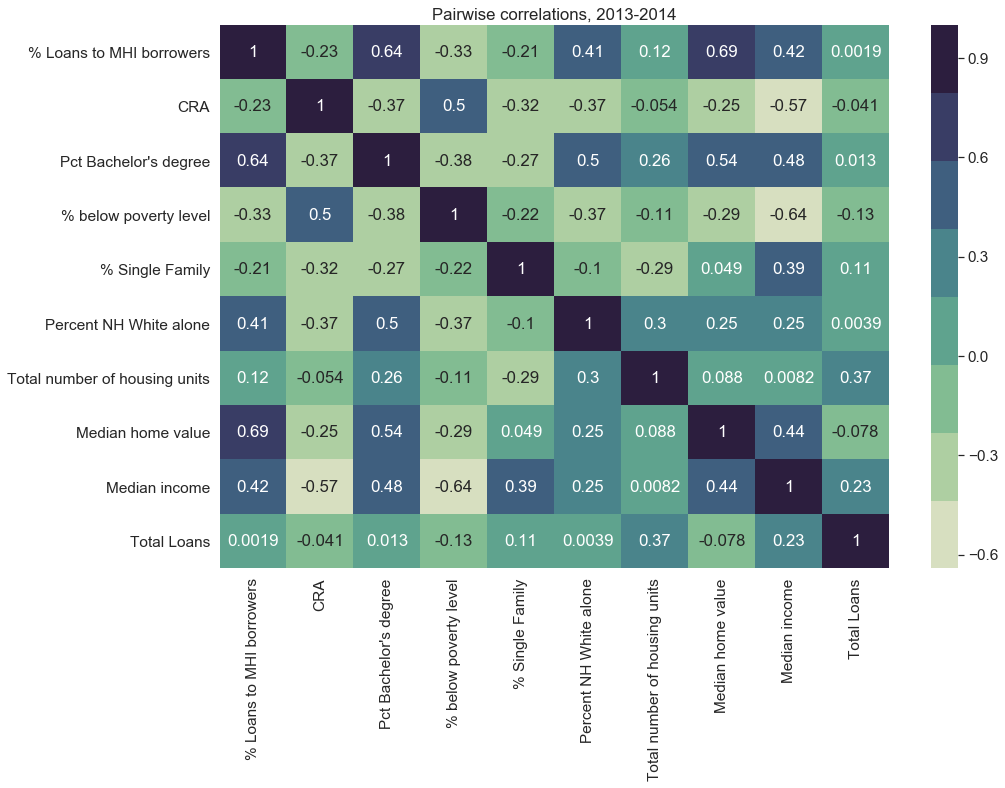

In [157]:
color = sns.cubehelix_palette(8, start=.5, rot=-.75)
sns.set(font_scale=1.4)
plt.subplots(figsize=(15,10))
sns.heatmap(x_vars_1314_corr, annot=True, cmap=color);
plt.title("Pairwise correlations, 2013-2014")
plt.savefig('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/screenshots/x_vars_1314_corr.png')




In [152]:

x_vars_151617_corr = x_vars_151617[['% Loans to MHI borrowers', 'CRA',
       'Pct Bachelor\'s degree',
       '% below poverty level', '% Single Family', 'Percent NH White alone',
       'Total number of housing units', 'Median home value', 'Median income',
       'Total Loans']].corr()
x_vars_151617_corr.head()


,% Loans to MHI borrowers,CRA,Pct Bachelor's degree,% below poverty level,% Single Family,Percent NH White alone,Total number of housing units,Median home value,Median income,Total Loans
% Loans to MHI borrowers,1.000000,-0.202621,0.559619,-0.285239,-0.144039,0.301371,0.034719,0.635779,0.353627,-0.064451
CRA,-0.202621,1.000000,-0.374424,0.501432,-0.321091,-0.371323,-0.053927,-0.251577,-0.568900,-0.041414
Pct Bachelor's degree,0.559619,-0.374424,1.000000,-0.381439,-0.269170,0.500695,0.256507,0.539556,0.476310,0.012930
% below poverty level,-0.285239,0.501432,-0.381439,1.000000,-0.216201,-0.366952,-0.109517,-0.290603,-0.641748,-0.125448
% Single Family,-0.144039,-0.321091,-0.269170,-0.216201,1.000000,-0.102036,-0.288723,0.049211,0.386841,0.113365


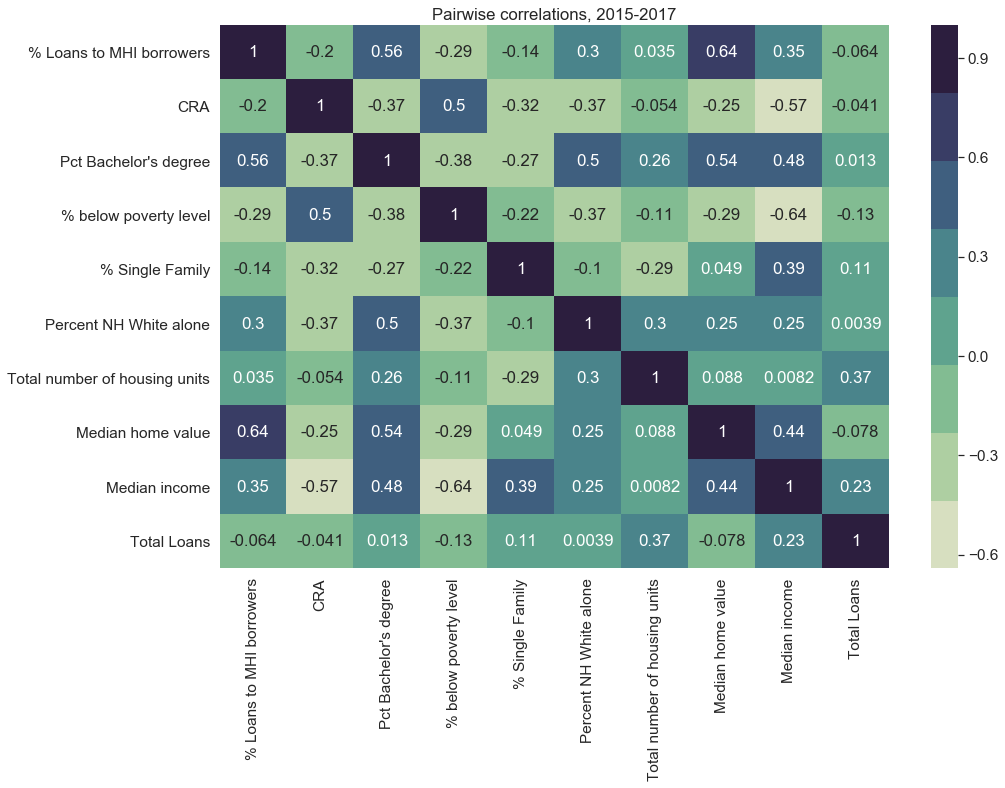

In [155]:
color = sns.cubehelix_palette(8, start=.5, rot=-.75)
sns.set(font_scale=1.4)
plt.subplots(figsize=(15,10))
sns.heatmap(x_vars_151617_corr, annot=True, cmap=color);
plt.title("Pairwise correlations, 2015-2017")
plt.savefig('/Users/ameliabaum/Desktop/Amelia/CRA_Thesis/communityreinvestmentact/results/screenshots/x_vars_151617_corr.png')


